In this notebook I evaluated the CIFAR10 dataset and trained an necessarily large Deep Neural Network using several bad practices and some good ones. The purpose behind this exercise was to demonstrate which combination of acitvation functions and optimizers help produce a faster, more accurate model. 

The aim of the notebook was: 
1. Use Tensorboard to help find the learning rate whenever you change the network architecture
2. I used ELU and SELU as the activation functions.
3. Explore what Batch Normalization does and its affect on speeding up trying by allowing a larger learning rate.
4. Apply AlphaDropout regularization with SELU as the activation function model and then use Monte Carlo (MC) Dropout. 
5. Use 1Cycle Scheduling 
6. Understand the importance of convergence speed and finding the best model with few epochs.  


<i>Please be mindful, in order for me to reduce run time of training the deep neural networks, I have reduced the batch_size and have only kept the best learning rates within the notebook, based on the 5 learning rates I applied per neural network architecture change. The purpose of this notebook is to understand what can be done to improve wall time and convergence rather than sitting around waiting for your model to train. I have kept one example below on how I searched for the best learning rate, by simply using a for loop and observing the best model (i.e. High Accuracy and Low Loss) for only 10 epochs. Furthermore, the accuracy of the models presented here can be signifcantly improved by reducing the number of layers and using a Conventional Neural Network.

In [1]:
#useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import os
tf.random.set_seed(42)
np.random.seed(42)

# Load Data

In [2]:
(X_train_val, y_train_val), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Explore Data

In [3]:
print(X_train_val.shape)
print(X_test.shape)
print(X_train_val[1].shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(32, 32, 3)


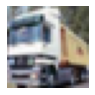

In [4]:
plt.figure(figsize= (1.5, 1.5))
plt.imshow(X_train_val[1]) #Image of a Truck
plt.axis('off')
plt.show()

In [5]:
X_train_val[1]

array([[[154, 177, 187],
        [126, 137, 136],
        [105, 104,  95],
        ...,
        [ 91,  95,  71],
        [ 87,  90,  71],
        [ 79,  81,  70]],

       [[140, 160, 169],
        [145, 153, 154],
        [125, 125, 118],
        ...,
        [ 96,  99,  78],
        [ 77,  80,  62],
        [ 71,  73,  61]],

       [[140, 155, 164],
        [139, 146, 149],
        [115, 115, 112],
        ...,
        [ 79,  82,  64],
        [ 68,  70,  55],
        [ 67,  69,  55]],

       ...,

       [[175, 167, 166],
        [156, 154, 160],
        [154, 160, 170],
        ...,
        [ 42,  34,  36],
        [ 61,  53,  57],
        [ 93,  83,  91]],

       [[165, 154, 128],
        [156, 152, 130],
        [159, 161, 142],
        ...,
        [103,  93,  96],
        [123, 114, 120],
        [131, 121, 131]],

       [[163, 148, 120],
        [158, 148, 122],
        [163, 156, 133],
        ...,
        [143, 133, 139],
        [143, 134, 142],
        [143, 133, 144]]

In [6]:
X_train_val.max() #confirm that the max value is 255, as with all RGB images

255

In [7]:
X_train_val.min() #confirm that the min value is 0, as with all RGB images

0

In [8]:
X_train_val[1].shape #32 x 32 pixel RGB image

(32, 32, 3)

In [9]:
X_train_val[1][30]

plt.figure(figsize= (1.5, 1.5))
plt.imshow(X_train_val[1][31]) #Slice of the Truck above (there are 32 slices)
plt.axis('off')
plt.show()

In [10]:
X_train_val[1][31].shape #Each slide has an RGB column vectors

(32, 3)

In [11]:
y_train_val[:20] #y values contain classes

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3],
       [4],
       [7],
       [7],
       [2],
       [9],
       [9],
       [9],
       [3],
       [2],
       [6]], dtype=uint8)

# Split Data into Train, Validation and Test

In [12]:
X_train, X_val = X_train_val[5000:], X_train_val[:5000]
y_train, y_val = y_train_val[5000:], y_train_val[:5000]

# Build Neural Network 
The first model will be larger than required but will provide a few good learning points.

In [13]:
from functools import partial

He_ELU_layer = partial(keras.layers.Dense,  kernel_initializer= 'he_normal', activation= 'elu')

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape= [32, 32, 3]))
for layer in range(20):
    model.add(He_ELU_layer(100))

model.add(keras.layers.Dense(10, activation= 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

# Compile Model - Callbacks, Optimizers, Loss, Metrics
First, create callbacks Tensor board, EarlyStopping and ModelCheckpoint

We will then use Nadam as the optimizer, where we will have to find the right learning rate.

In [14]:
#Early stopping and Model checkpoint Callbacks are easy to implement
early_stoppping_cb= keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb= keras.callbacks.ModelCheckpoint('CIFA10_model.h5', save_best_only=True) #save the best model

run_index=6 #change values of the run index so we can plot all learning curves on tensorboard 
#create log directory
run_log = os.path.join(os.curdir, 'CIFAR10_data_logs', "run_{:03d}".format(run_index))

tensorboard_cb = keras.callbacks.TensorBoard(run_log) 
callbacks = [early_stoppping_cb, model_checkpoint_cb, tensorboard_cb]

Now, let's find the right learning rate for Nadam using the tensorboard learning rate plot for the first 10 epochs.

__Fire up the tensorboard__ by first setting the file path to the Jupyter notebook's directory then through the command line load tensorboard,  with the flag --logdir=< The location of your log files > and --port=6006.

I used Tensorboard to find the learning rate used (below). My previous Runs has learning rates 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.00003,  

__note__: If you have loaded a previous tensorboard server before - through Jupyter notebook OR command line - ensure that this is closed. You can make sure by closing the notebook (plus powershell) and starting it again. I learnt this the hard way. You can also see the location of the current working directory that the tensorboard is using on the bottom left, ensure this the location of where you are saving your logs.

In [15]:
optimizer =  keras.optimizers.Nadam(learning_rate= 5e-5)

model.compile(optimizer= optimizer,
             loss= 'sparse_categorical_crossentropy',
             metrics= ['accuracy'])

# Train ELU Model with Epochs, Validation Data, Callbacks

In [16]:
model.fit(X_train, y_train, epochs= 10,
                   validation_data=(X_val, y_val),
                    callbacks= [callbacks])

Epoch 1/10
1407/1407 [==============================] - 29s 21ms/step - loss: 4.0040 - accuracy: 0.1692 - val_loss: 2.2040 - val_accuracy: 0.2220
Epoch 2/10
1407/1407 [==============================] - 26s 18ms/step - loss: 2.0494 - accuracy: 0.2545 - val_loss: 1.9715 - val_accuracy: 0.2738
Epoch 3/10
1407/1407 [==============================] - 29s 20ms/step - loss: 1.9249 - accuracy: 0.2970 - val_loss: 1.9274 - val_accuracy: 0.2976
Epoch 4/10
1407/1407 [==============================] - 24s 17ms/step - loss: 1.8480 - accuracy: 0.3286 - val_loss: 1.9271 - val_accuracy: 0.3064
Epoch 5/10
1407/1407 [==============================] - 23s 17ms/step - loss: 1.7850 - accuracy: 0.3526 - val_loss: 1.8405 - val_accuracy: 0.3282
Epoch 6/10
1407/1407 [==============================] - 26s 18ms/step - loss: 1.7365 - accuracy: 0.3735 - val_loss: 1.7234 - val_accuracy: 0.3660
Epoch 7/10
1407/1407 [==============================] - 23s 17ms/step - loss: 1.6839 - accuracy: 0.3920 - val_loss: 1.6635 -

In [17]:
#load best model 
model = keras.models.load_model('CIFA10_model.h5')
model.evaluate(X_val, y_val)

157/157 [==============================] - 1s 4ms/step - loss: 1.6351 - accuracy: 0.4064


[1.6350537538528442, 0.40639999508857727]

I started training the above before dinner and the accuracy had not improved much, considering the long training time length there was no point continuing training. This model is clearly not great for our dataset. We should try adding Batch Normalization. 

Note, I will now save the logs to a new directory called RunNB. 

In [18]:
keras.backend.clear_session()

# ELU with Batch Normalization 
BN with ELU will help reduce wall time so let's add this into the layers.
I will add the code in one cell for convenience. 

There is debate about implementing BN before the Dense layer or activation function, to save a bit of typing let's try before and after. The code looks more beautiful to me. 

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape= [32, 32, 3]))

#20 hidden layers with BN before
for _ in range(20):
    model.add(keras.layers.BatchNormalization())
    model.add(He_ELU_layer(100))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation= 'softmax'))

#callbacks
early_stopping_cb =keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = keras.callbacks.ModelCheckpoint('CIFAR10_BN_ELU.h5', save_best_only=True)

for lr in (1e-4, 3e-4, 5e-4, 1e-3, 3e-3):
    run_nb = os.path.join('CIFAR10_data_logs', 'Run_NB_LR_{}'.format(lr))
    #compile model 
    tensorboard_cb = keras.callbacks.TensorBoard(run_nb)
    
    optimizer= keras.optimizers.Nadam(learning_rate= lr)
    
    model.compile(loss= keras.losses.sparse_categorical_crossentropy, metrics= ['accuracy'], optimizer=optimizer)
    
    model.fit(X_train, y_train, epochs= 10, validation_data= (X_val, y_val), 
              callbacks= [early_stopping_cb, checkpoint_cb, tensorboard_cb])
    keras.backend.clear_session()


Epoch 1/10
1407/1407 [==============================] - 54s 39ms/step - loss: 2.1339 - accuracy: 0.2428 - val_loss: 1.8305 - val_accuracy: 0.3358
Epoch 2/10
1407/1407 [==============================] - 40s 29ms/step - loss: 1.8540 - accuracy: 0.3354 - val_loss: 1.7101 - val_accuracy: 0.3798
Epoch 3/10
1407/1407 [==============================] - 40s 29ms/step - loss: 1.7573 - accuracy: 0.3717 - val_loss: 1.6322 - val_accuracy: 0.4084
Epoch 4/10
1407/1407 [==============================] - 41s 29ms/step - loss: 1.6908 - accuracy: 0.3953 - val_loss: 1.5784 - val_accuracy: 0.4340
Epoch 5/10
1407/1407 [==============================] - 40s 28ms/step - loss: 1.6394 - accuracy: 0.4166 - val_loss: 1.5385 - val_accuracy: 0.4512
Epoch 6/10
1407/1407 [==============================] - 39s 28ms/step - loss: 1.5962 - accuracy: 0.4320 - val_loss: 1.4991 - val_accuracy: 0.4610
Epoch 7/10
1407/1407 [==============================] - 39s 28ms/step - loss: 1.5567 - accuracy: 0.4464 - val_loss: 1.4941 -

1407/1407 [==============================] - 39s 28ms/step - loss: 1.2589 - accuracy: 0.5647 - val_loss: 1.4005 - val_accuracy: 0.5230
Epoch 10/10
1407/1407 [==============================] - 39s 27ms/step - loss: 1.2354 - accuracy: 0.5729 - val_loss: 1.3931 - val_accuracy: 0.5302


In [20]:
model = keras.models.load_model('CIFAR10_BN_ELU.h5')
model.evaluate(X_val, y_val)

157/157 [==============================] - 1s 5ms/step - loss: 1.3457 - accuracy: 0.5386


[1.3457212448120117, 0.5386000275611877]

A bigger gain (but still not great~52%) and Batch Normalization provided a faster convergence due to the larger learning rate.

# SELU Activation
First we need to do a bit of preprocessing, by using standardizing the inputs and using LeCun normal initialization


## Preprocessing Step - Standardizing Features
Before we train a network that uses the selu activation function we need the input values need to be scaled, as the values vary from 0 to 255.

In [21]:
pixel_means = X_train.mean(axis=0)
pixel_std = X_train.std(axis=0)

X_train_scaled = (X_train - pixel_means)/pixel_std
X_val_scaled = (X_val - pixel_means)/pixel_std
X_test_scaled = (X_test - pixel_means)/pixel_std

## Build Model 
Specify SELU as the activation function and LeCun Normal as the initializer

In [22]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape= [32, 32, 3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, activation= 'selu', kernel_initializer= 'lecun_normal'))

model.add(keras.layers.Dense(10, activation= 'softmax'))


optimizer = keras.optimizers.Nadam(lr= 7e-4)

model.compile(loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'], optimizer= optimizer)

#callbacks
early_stopping_cb =keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = keras.callbacks.ModelCheckpoint('CIFAR10_SELU.h5', save_best_only=True)

run_selu = os.path.join('CIFAR10_data_logs', 'Run_SELU')
tensorboard_cb = keras.callbacks.TensorBoard(run_nb)

model.fit(X_train_scaled, y_train, validation_data= (X_val_scaled, y_val), epochs=10,
         callbacks= [early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/10
1407/1407 [==============================] - 40s 28ms/step - loss: 1.9229 - accuracy: 0.3109 - val_loss: 1.8449 - val_accuracy: 0.33780s - loss: 1.9233 - accuracy: 0.
Epoch 2/10
1407/1407 [==============================] - 27s 19ms/step - loss: 1.7000 - accuracy: 0.3983 - val_loss: 1.7956 - val_accuracy: 0.3634
Epoch 3/10
1407/1407 [==============================] - 28s 20ms/step - loss: 1.6089 - accuracy: 0.4330 - val_loss: 1.7202 - val_accuracy: 0.3852
Epoch 4/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.5438 - accuracy: 0.4567 - val_loss: 1.6349 - val_accuracy: 0.4362
Epoch 5/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.4876 - accuracy: 0.4797 - val_loss: 1.5665 - val_accuracy: 0.4538
Epoch 6/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.4426 - accuracy: 0.4986 - val_loss: 1.5138 - val_accuracy: 0.4788
Epoch 7/10
1407/1407 [==============================] - 27s 19ms/step - loss: 1.4007 - accur

In [23]:
model = keras.models.load_model('CIFAR10_SELU.h5')
model.evaluate(X_val_scaled, y_val)

157/157 [==============================] - 1s 5ms/step - loss: 1.4522 - accuracy: 0.5034


[1.4522297382354736, 0.5034000277519226]

Not much of a gain in performance when compared with the model that had the BN layers but it was better than the original elu model and it definetly did converge faster - both in terms of number of epochs and training time per epoch. 

#### Applying Alpha Dropout 
As we are using SELU we need to apply Alpha Dropout. 

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#build model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape= [32, 32, 3]))

for _ in range(20):
    model.add(keras.layers.Dense(100,activation='selu', kernel_initializer= 'he_normal'))
model.add(keras.layers.AlphaDropout(rate=0.2))
model.add(keras.layers.Dense(10, activation= 'softmax'))

#compile build
lr= 1e-3 #change this and use tensorboard to find the best learning rate
optimizer= keras.optimizers.Nadam(learning_rate= lr)
model.compile(optimizer= optimizer, loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

#callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint('CIFAR10_data_ADrop.h5', save_best_only=True)

alpha_dir = os.path.join('CIFAR10_data_logs', 'Run_lr={}'.format(lr))
tensorboard_cb = keras.callbacks.TensorBoard(alpha_dir)

model.fit(X_train_scaled, y_train, epochs=10, validation_data= (X_val_scaled, y_val),
         callbacks= [early_stopping_cb, checkpoint_cb, tensorboard_cb])


Epoch 1/10
1407/1407 [==============================] - 34s 24ms/step - loss: 2.1196 - accuracy: 0.2286 - val_loss: 1.8628 - val_accuracy: 0.2972
Epoch 2/10
1407/1407 [==============================] - 35s 25ms/step - loss: 1.8733 - accuracy: 0.3000 - val_loss: 1.8414 - val_accuracy: 0.3102
Epoch 3/10
1407/1407 [==============================] - 29s 20ms/step - loss: 1.7901 - accuracy: 0.3407 - val_loss: 1.9635 - val_accuracy: 0.3236
Epoch 4/10
1407/1407 [==============================] - 27s 19ms/step - loss: 1.7256 - accuracy: 0.3648 - val_loss: 1.7505 - val_accuracy: 0.3758
Epoch 5/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.7456 - accuracy: 0.3576 - val_loss: 1.7706 - val_accuracy: 0.3842
Epoch 6/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.6727 - accuracy: 0.3960 - val_loss: 1.6914 - val_accuracy: 0.4046
Epoch 7/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.6171 - accuracy: 0.4197 - val_loss: 1.6802 -

In [25]:
model = keras.models.load_model('CIFAR10_data_ADrop.h5')
model.evaluate(X_val_scaled, y_val)

157/157 [==============================] - 1s 5ms/step - loss: 1.6442 - accuracy: 0.4330


[1.6441736221313477, 0.43299999833106995]

Not much of an improvement with the data, we should try use MCDropout too, but I do not think this will improve the performance much. 

In [26]:
#create MCDropout class

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

#create a model using the Alpha Dropout model just trained
# We create an identical model but replace all Alphadropout layers with MCAlpha Dropout
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers
])


In [27]:
mc_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

In [28]:
#Lets add 2 functions that helps find the mean class prediction and using that mean returns the class for that instance

def mc_dropout_predict_probas(model, X, n_samples=10):
    Y_proba = [model.predict(X) for sample in range(n_samples)] #run the prediction n_samples, different neurons will dropout
    return np.mean(Y_proba, axis=0)

def mc_dropout_predict_class(model, X, n_samples=10):
    Y_proba = mc_dropout_predict_probas(model, X, n_samples=10)
    return np.argmax(Y_proba, axis=1)

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_class(mc_model, X_val_scaled)
np.mean(y_pred == y_val.reshape(1,-1)[0])

0.4326

The accuracy did not improve from 43.29% to 43.26%. The best model we have is Batch Normalization with ELU. 

1Cycle is known to speed up convergence and accuracy so we will give that a go.

### 1Cycle Learning Rate Scheduling 

In [30]:
#Make a 1Cycle Scheduling 

In [31]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate= None, last_iterations= None, last_rate= None):
        self.iterations= iterations
        self.max_rate= max_rate
        self.start_rate= start_rate or max_rate/10
        self.last_iterations= last_iterations or iterations//10 + 1
        self.half_iteration= (iterations - self.last_iterations) // 2
        self.last_rate= last_rate or self.start_rate/1000
        self.iteration = 0
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2*self.half_iteration, self.max_rate, self.start_rate)
        
        else:
            rate = self._interpolate(2*self.half_iteration, self.iterations, self.start_rate, self.last_rate)
            
            rate= max(rate, self.last_rate)
        self.iteration+=1
        keras.backend.set_value(self.model.optimizer.lr, rate)

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr= 1e-3)
model.compile(optimizer= optimizer, loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])


The code below can be copied to apply on any  model. 

In [33]:
#To plot the losses and lr-rates we need tensorflow to return these values at the end of each batch. So we use a callback.
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        keras.backend.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)


# before we train the model we need to plot the best learning rates, let's define function to plot that
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate= 10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) //batch_size * epochs
    factor = np.exp(np.log(max_rate/min_rate)/iterations)
    init_lr = keras.backend.get_value(model.optimizer.lr)
    keras.backend.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size= batch_size, callbacks= [exp_lr])
    keras.backend.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), losses[0]+min(losses)/2])
    plt.xlabel('Learning Rate')
    plt.ylabel('Losses')

352/352 [==============================] - 11s 30ms/step - loss: 86.8612 - accuracy: 0.1418


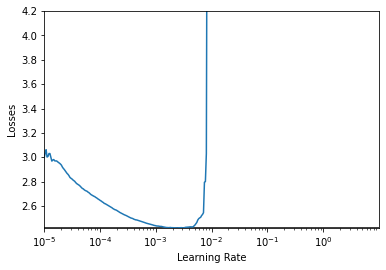

In [34]:
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size= 128)
plot_lr_vs_loss(rates, losses)

In [35]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
    
model.add(keras.layers.AlphaDropout(rate= 0.1))
model.add(keras.layers.Dense(10, activation= 'softmax'))

optimizer= keras.optimizers.Nadam(lr= 0.01)
model.compile(optimizer= optimizer, loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])


In [36]:
#call the 1Cycle class
# number of instances/ batchsize*epochs
onecycle= OneCycleScheduler(len(X_train_scaled)//128*15, max_rate= 0.05)

history = model.fit(X_train_scaled, y_train, validation_data= (X_val_scaled, y_val),
                   epochs=20, callbacks=[onecycle])

Epoch 1/20
1407/1407 [==============================] - 26s 18ms/step - loss: 1357660502884352.0000 - accuracy: 0.1050 - val_loss: 3.0146 - val_accuracy: 0.1038
Epoch 2/20
1407/1407 [==============================] - 25s 18ms/step - loss: 2.5525 - accuracy: 0.1001 - val_loss: 3.7573 - val_accuracy: 0.1040
Epoch 3/20
1407/1407 [==============================] - 25s 18ms/step - loss: 2.4269 - accuracy: 0.0993 - val_loss: 2.6997 - val_accuracy: 0.0920
Epoch 4/20
1407/1407 [==============================] - 28s 20ms/step - loss: 2.3238 - accuracy: 0.0996 - val_loss: 2.3070 - val_accuracy: 0.1010
Epoch 5/20
1407/1407 [==============================] - 26s 18ms/step - loss: 2.3034 - accuracy: 0.1007 - val_loss: 2.3049 - val_accuracy: 0.1010
Epoch 6/20
1407/1407 [==============================] - 26s 19ms/step - loss: 2.3028 - accuracy: 0.0994 - val_loss: 2.3044 - val_accuracy: 0.1010
Epoch 7/20
1407/1407 [==============================] - 26s 18ms/step - loss: 2.3027 - accuracy: 0.1006 - val

In [37]:
model.evaluate(X_val_scaled, y_val)

157/157 [==============================] - 1s 4ms/step - loss: 2.3042 - accuracy: 0.1010


[2.304230213165283, 0.10100000351667404]

The model is training faster than previously, we saw 36 seconds per epoch without 1Cycle and now we are seeing around ~26seconds. This is almost a 30% increase in speed and almost half as fast compared to Batch Normalization with ELU ~50seconds. 

Alebit all models were trained with small batchsizes, you can still identify which combination of initialization, normalization, activation function, optimizer and learning rate scheduling helps reduce the number of epochs and convergence time.

The question to ask, does faster convergence time offset the increase in accuracy? In reality, and under a production environment, I would be cautious with the hyperparameter tuning and the hopefully use some sort of cloud based platform to help speed up training. 

## In summary

For Deep Neural networks use the following configuration (<i>as a rule of thumb, this may change based on application</i>):
<li>Kernal Initializer = <b>LeCun Initializer</b> </li>
<li>Activation Function = <b>SELU</b></li>
<li>Normalization = <b>None</b></li>
<li>Regularization = <b>AlphaDropout</b></li>
<li>Optimizer = <b>Momentum Optimization (or RM Prop or Nadam</b></li>
<li>Learning Rate Schedule = <b>1Cycle</b></li>

Don't forget to add in ModelCheckpoint and Tensorboard Callbacks.